In [27]:
# Importieren der benötigten Bibliotheken
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from logging import warning
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
# import pandas as pd

# # Pfad zur CSV-Datei
# csv_path = 'C:/Users/busse/CICDPipeline/BA-CICD-Pipeline/model/gender.csv'

# # Laden der CSV-Datei in einen DataFrame
# df = pd.read_csv(csv_path)
# print(len(df))
# # Konvertierung der Werte aus der Spalte 'gender' in ein Array
# gender_labels = df['Male'].values
# len(gender_labels)


In [29]:
BASE_DIR = 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba'
image_paths = []
image_filenames = os.listdir(BASE_DIR)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  image_paths.append(image_path)

len(image_paths)
image_paths

  0%|          | 0/202599 [00:00<?, ?it/s]

['C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000001.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000002.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000003.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000004.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000005.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000006.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000007.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000008.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000009.jpg',
 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba\\000

In [30]:

list_attr_celebaCSV = 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/list_attr_celeba.csv'
df = pd.read_csv(list_attr_celebaCSV)
df_Male = df["Male"]
df_Male = df_Male.replace(-1, 0)
df_gender = df_Male.values
df_gender

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [31]:

df = pd.DataFrame({'Images':image_paths, 'Gender': df_gender})
df.head()

,Images,Gender
0,C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...,0
1,C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...,0
2,C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...,1
3,C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...,0
4,C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...,0


In [32]:
first_row = df.iloc[0]

print(first_row)

Images    C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Ge...
Gender                                                    0
Name: 0, dtype: object


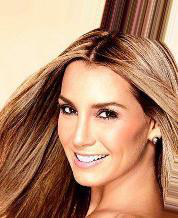

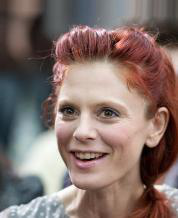

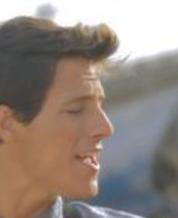

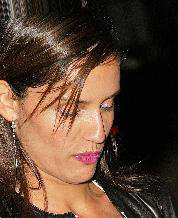

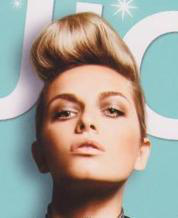

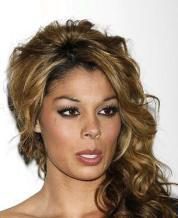

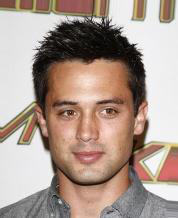

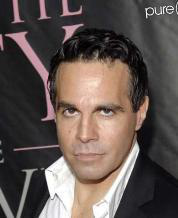

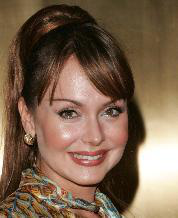

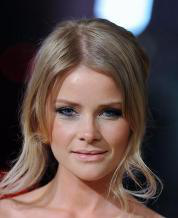

In [33]:

image_df = df.drop("Gender", axis=1)

i = 0
while i != 10: 
    img = Image.open(image_df.iloc[i][0])
    display(img)
    i += 1




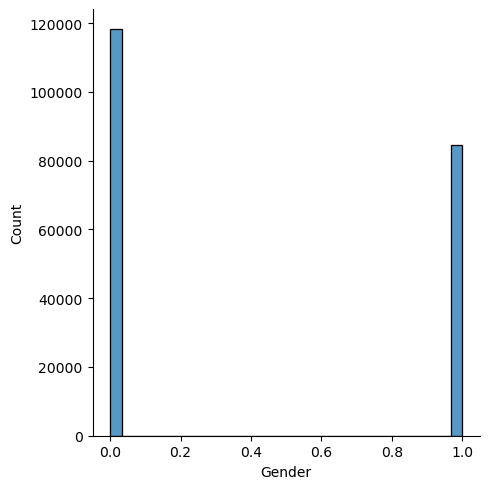

In [34]:
sns.displot(df["Gender"])

2000


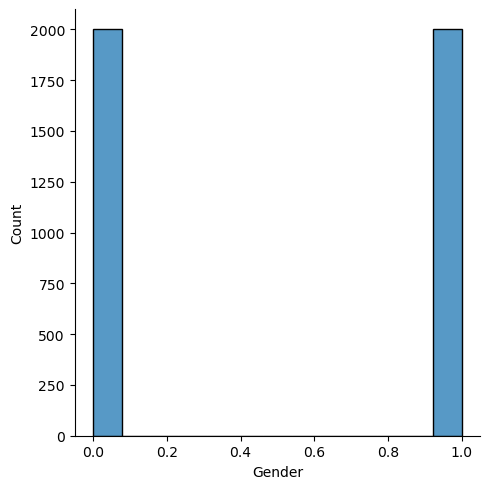

In [35]:


def find_file(filename, directory):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None


class StopExecution(Exception):
    def _render_traceback_(self):
        pass

n = 2000

directory = 'C:/Users/busse/CICDPipeline/BA-CICD-Pipeline/model'
filename = f'trained_{n}_model.h5'  
file_path = find_file(filename, directory)
# file_name = os.path.basename(file_path)  


# if file_name == filename:
#     print(f'Fehler: Die Datei {filename} ist bereits vorhanden! : {file_path}')

#     raise StopExecution()

    
# if file_path is None:
#     print(f'Die Datei {filename} wurde nicht gefunden.')
# else:
#     print(f'Die Datei {filename} wurde gefunden unter: {file_path}')

print(n)
df_sample = df.groupby('Gender', group_keys=False).apply(lambda x: x.sample(n=n, random_state=42))
sns.displot(df_sample["Gender"])
df_sample

df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
df_sample.to_excel(f'Gender_{n}.xlsx', index=False)



In [36]:



def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        
        img = img.resize((178, 218), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 178, 218, 1)
    return features

In [37]:
X = extract_image_features(df_sample['Images'])

  0%|          | 0/4000 [00:00<?, ?it/s]

In [38]:
# X.shape


# np.save('features.npy', X)

In [39]:
# import os
# import shutil

# # Pfad zum Ordner mit den Bildern
# path = 'C:/Users/busse/CICDPipeline/BA-CICD-Pipeline/data/img_align_celeba'

# # Pfad zum Zielordner
# destination = 'C:/Users/busse/OneDrive/Desktop/TestPY'

# # Liste aller Dateien im Ordner
# files = os.listdir(path)

# # Schleife zum Kopieren jeder Datei
# for i, file in enumerate(files):
#     if i >= 10000:
#         break
#     # Pfad zur aktuellen Datei
#     current_file_path = os.path.join(path, file)
#     # Pfad zur neuen Datei
#     new_file_path = os.path.join(destination, file)
#     # Kopieren der Datei
#     shutil.copy(current_file_path, new_file_path)

In [40]:
# loaded_X = np.load('features.npy')
X = X / 255.0

In [41]:
X.shape

(4000, 178, 218, 1)

In [42]:


y_gender = np.array(df_sample['Gender'])

len(y_gender)

4000

In [43]:


class MyCallback(Callback):
    def __init__(self, threshold):
        super(MyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            self.model.stop_training = True
            # Save the model
            self.model.save(f'{n}.h5') 


In [44]:


# Assuming X is your feature set and y_gender is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y_gender, test_size=0.2, random_state=42)


input_shape = (178, 218, 1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(4, 4), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
# dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
# dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)

# output = Dense(1, activation='sigmoid')(flatten)
model = Model(inputs=[inputs], outputs=[output_1])
# model = Model(inputs=[inputs], outputs=[output])


# Define the early stopping criteria
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

model.compile(loss=['binary_crossentropy', 'mae'],optimizer='adam', metrics=['accuracy'])





In [45]:
print(len(y_train))
print(len(X_train))

checkpoint_path = "training/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=10)


3200
3200


In [46]:
model.fit(x=X_train, y=y_train,batch_size=32, epochs=30, validation_data=(X_test,y_test),callbacks=[cp_callback])

Epoch 1/30


100/100 [==============================] - 31s 305ms/step - loss: 0.6817 - accuracy: 0.5572 - val_loss: 0.6708 - val_accuracy: 0.5738
Epoch 2/30
100/100 [==============================] - 29s 290ms/step - loss: 0.6368 - accuracy: 0.6363 - val_loss: 0.5986 - val_accuracy: 0.6737
Epoch 3/30
100/100 [==============================] - 31s 308ms/step - loss: 0.6046 - accuracy: 0.6766 - val_loss: 0.5639 - val_accuracy: 0.6963
Epoch 4/30
100/100 [==============================] - 28s 284ms/step - loss: 0.5798 - accuracy: 0.6928 - val_loss: 0.5681 - val_accuracy: 0.7138
Epoch 5/30
100/100 [==============================] - 30s 302ms/step - loss: 0.5703 - accuracy: 0.6950 - val_loss: 0.5395 - val_accuracy: 0.7075
Epoch 6/30
100/100 [==============================] - 29s 286ms/step - loss: 0.5505 - accuracy: 0.7181 - val_loss: 0.5648 - val_accuracy: 0.6975
Epoch 7/30
100/100 [==============================] - 29s 286ms/step - loss: 0.5355 - accuracy: 0.7278 - val_loss: 0.5418 - val_

In [47]:
model.save(f"trained_{n}_model.h5")

In [48]:

loaded_model = load_model(f'trained_{n}_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy * 100}')
predictions = loaded_model.predict(X)

predictions

Accuracy: 85.87499856948853
125/125 [==============================] - 11s 87ms/step


array([[1.4963017e-14],
       [9.9995947e-01],
       [1.2170209e-10],
       ...,
       [3.2994943e-05],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [49]:

img = load_img('C:/Users/busse/CICDPipeline/BA-CICD-Pipeline/data/test_images/w6.jpg', target_size=(178, 218), color_mode="grayscale")

img_array = img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

predictions = loaded_model.predict(img_array)

if predictions[0] < 0.5:
    print(f'Frau:{predictions}')
else:
    print(f'Mann:{predictions}') 


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/busse/CICDPipeline/BA-CICD-Pipeline/data/test_images/w6.jpg'